In [1]:
import sys  
sys.path.insert(1, '../../')

import re
import numpy as np
import segyio
import matplotlib.pyplot as plt
from devito import TimeFunction, Eq, solve, Operator, configuration
from scratch.util import plot_seis_data, plot_rec_src, read_radex_picks
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, Receiver, plot_shotrecord

configuration['ignore-unknowns'] = True
#Закоменти, чтобы выполнять на CPU
from devito import configuration
#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [2]:
spacing=(1,1)
shape=(2000, 400)
origin=(0,0)
nbl=500

vmod = np.loadtxt("../../Data/Oshkin_vankor_model/model_vp_gis3.txt", dtype=np.float32)
v = np.tile(vmod, (shape[0], 1))

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, space_order=8, nbl=nbl, bcs="damp")


Operator `initdamp` ran in 0.09 s


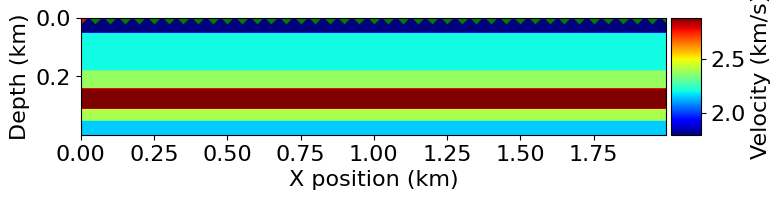

In [3]:
t0=0
tn=1000
f0=0.050
dt=model.critical_dt

time_range = TimeAxis(start=t0, stop=tn, step=dt)

nsrc=1
nrec=81

src = RickerSource(name="src", grid = model.grid, f0=f0, npoint=nsrc, time_range=time_range)

rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:,0] = np.linspace(0, model.domain_size[0]+1, num=nrec)
rec.coordinates.data[:,1] = 0

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::2, :])

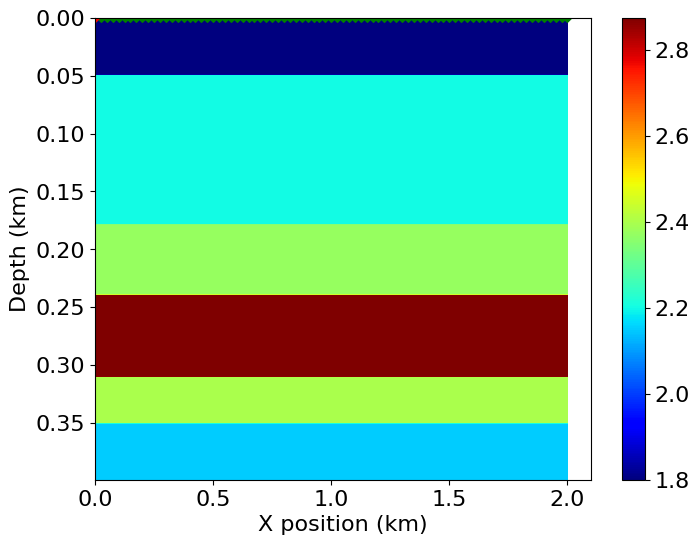

In [4]:
plot_rec_src(model, "vp", src.coordinates.data[:], rec.coordinates.data[:])

In [5]:
# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

stencil = Eq(u.forward, solve(pde, u.forward))

# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [6]:
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
summary = op.apply(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 1.90 s


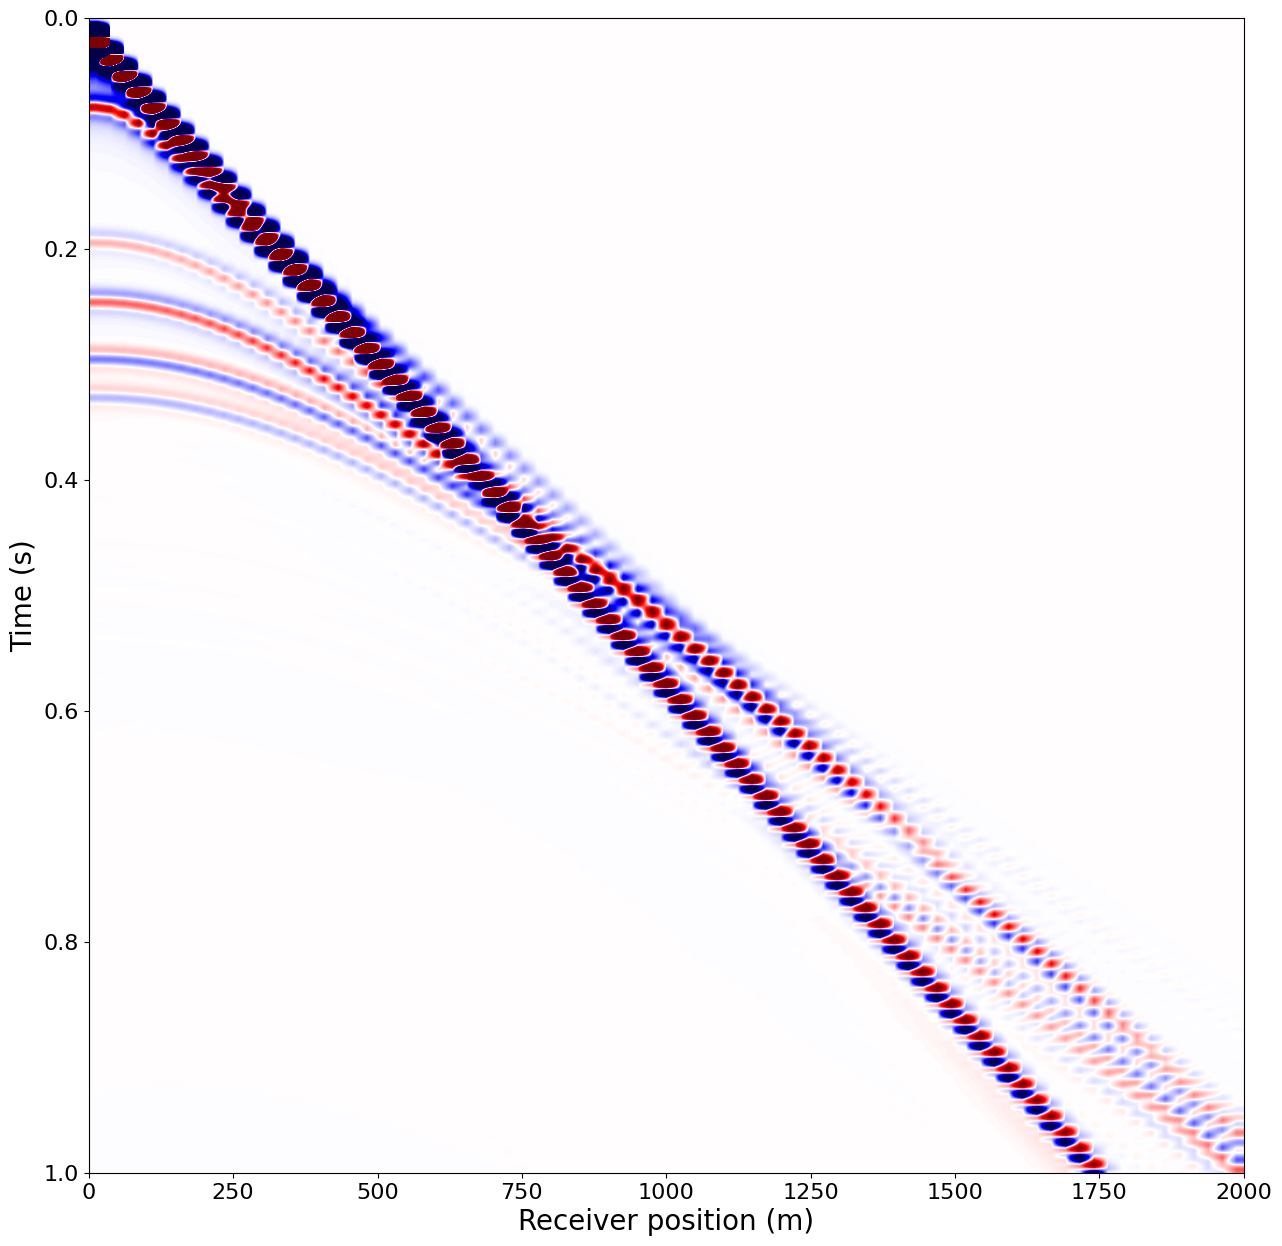

In [7]:
plot_seis_data(rec.coordinates.data[:], rec.data, t0, tn, gain=1e2)

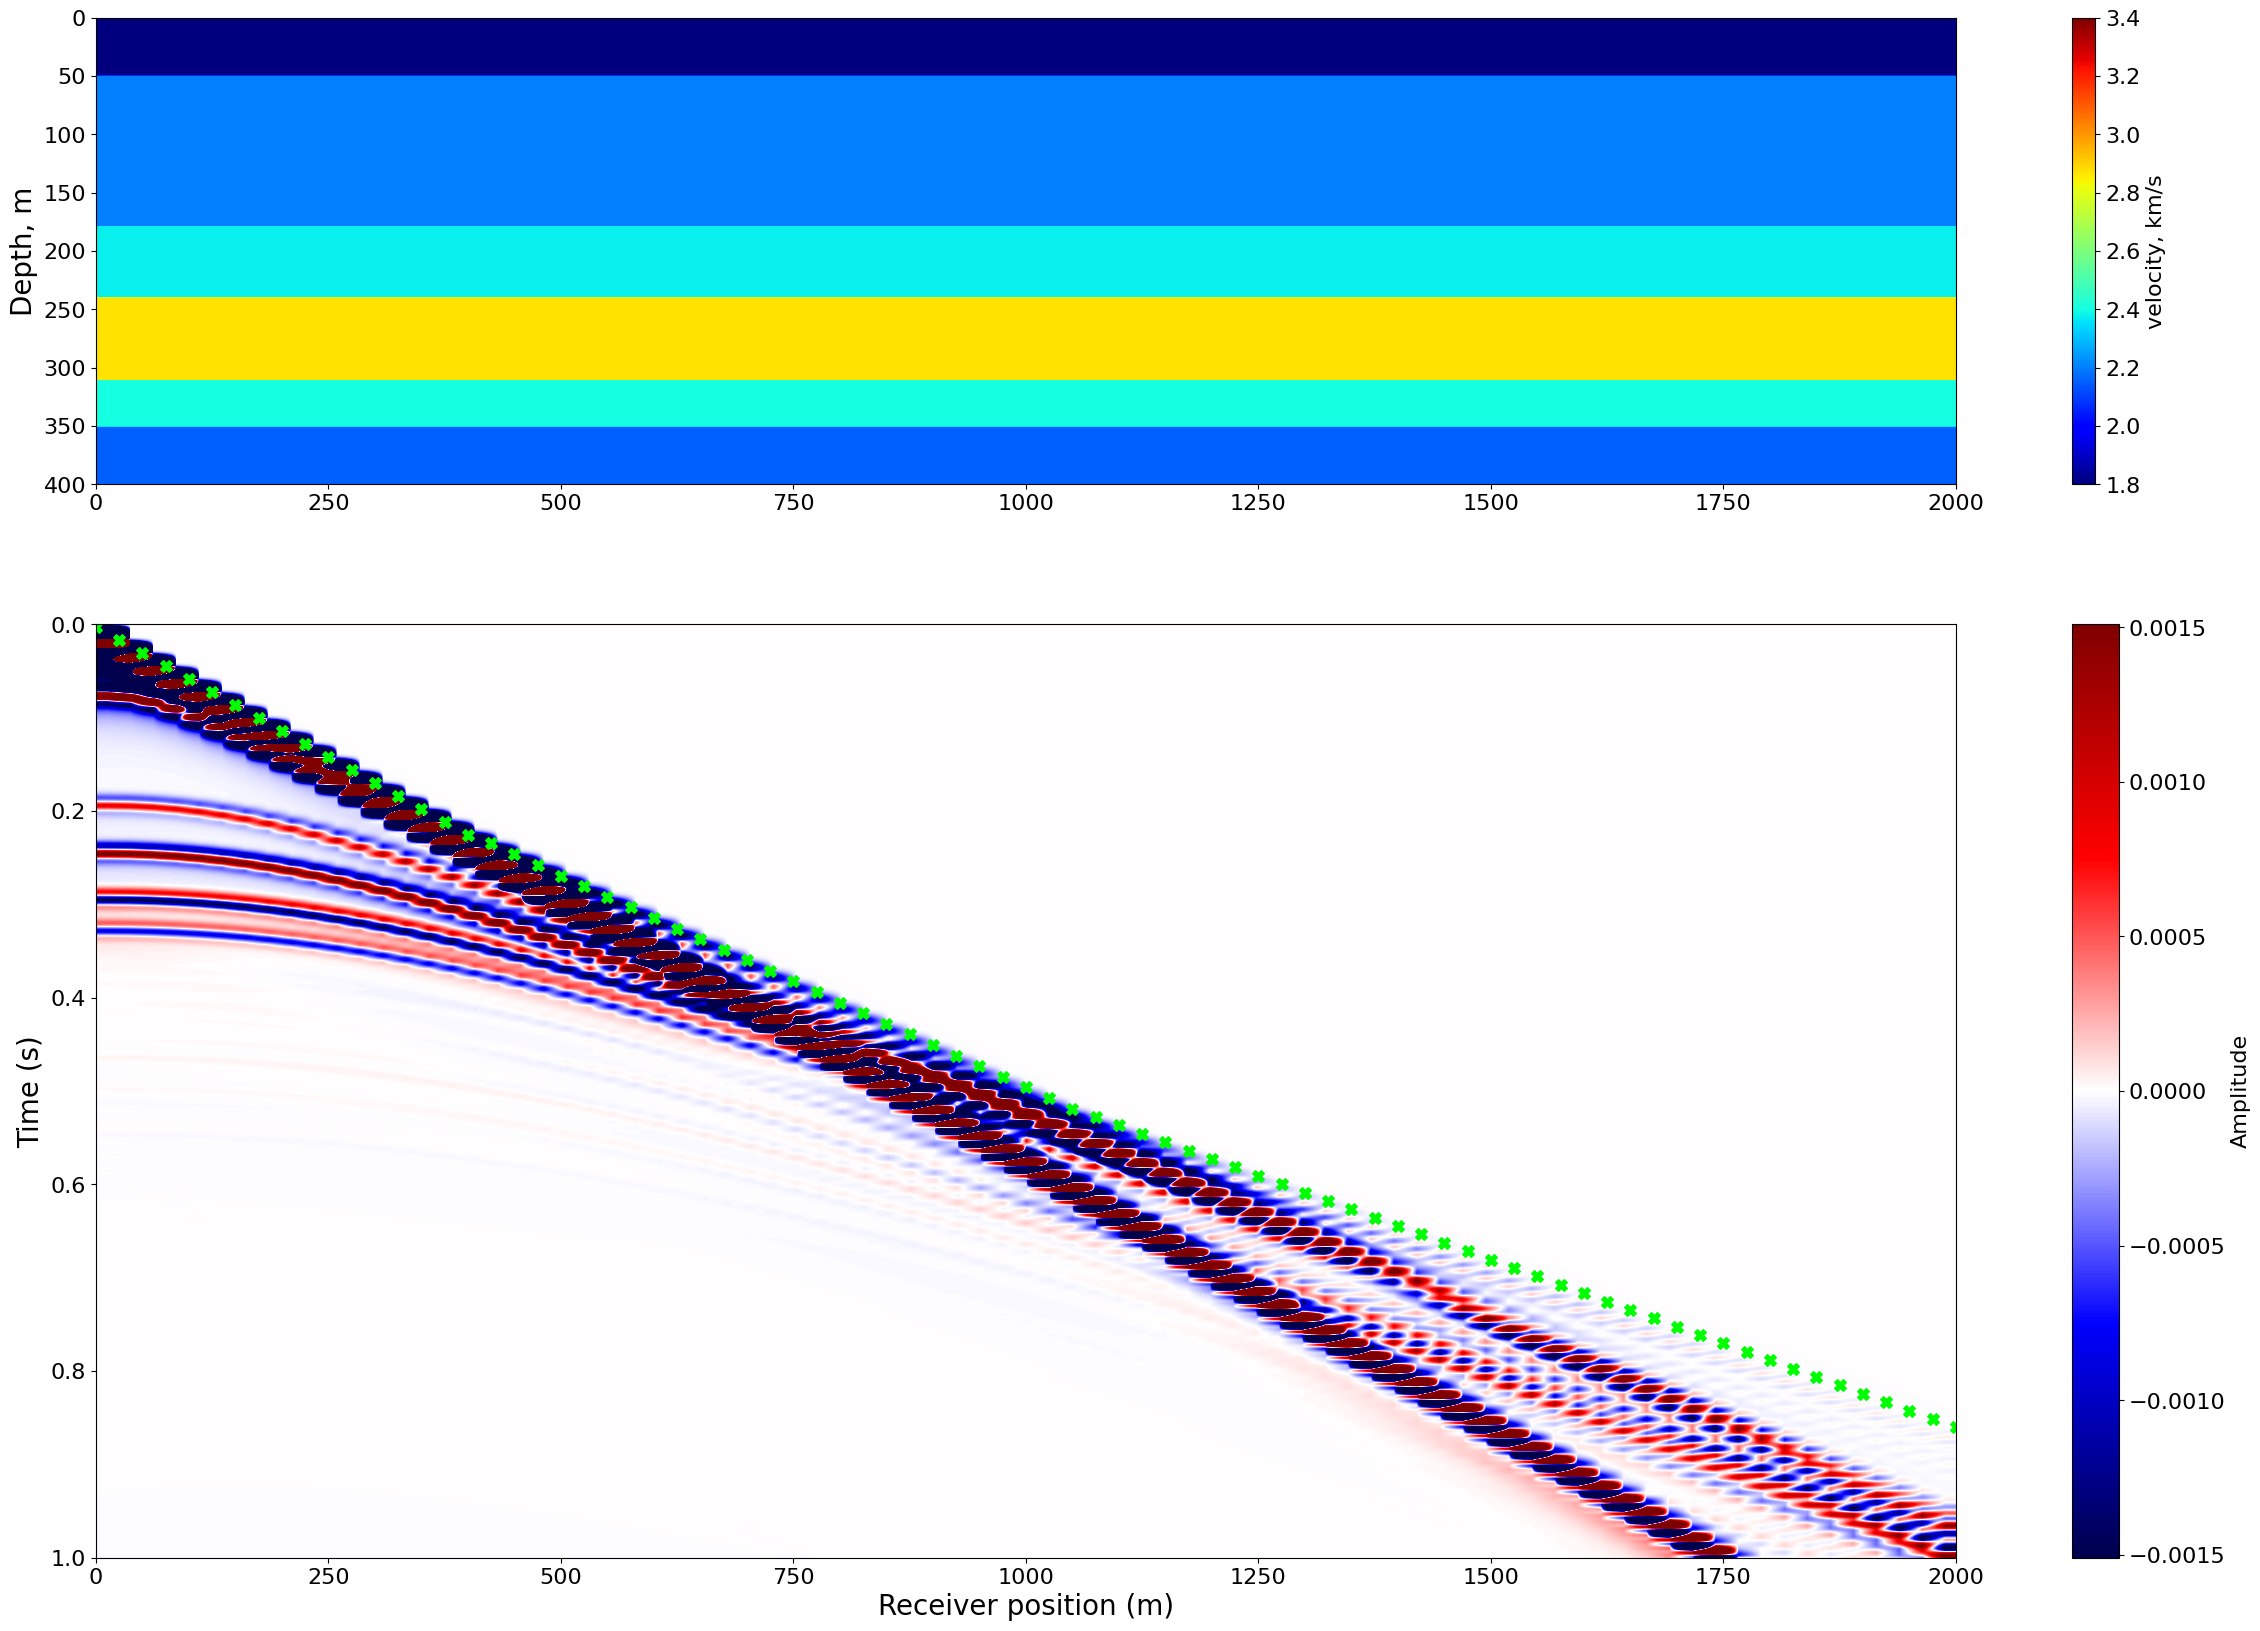

In [8]:
picks = read_radex_picks('OSHK_PICK (2).txt')
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 4]})
fig.set_size_inches(30,20)

extent = [rec.coordinates.data[0, 0], rec.coordinates.data[-1, 0], 400, 0]
slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
field = np.transpose(model.vp.data[slices])
cb1 = axs[0].imshow(field, cmap="jet", extent=extent, aspect='auto', vmin=1.8, vmax=3.4)
axs[0].set_ylabel("Depth, m", fontsize=20)

extent = [rec.coordinates.data[0, 0], rec.coordinates.data[-1, 0], 1e-3*tn, t0]
vminmax = np.max(np.abs(rec.data))
gain=4e2
sc = vminmax/gain

cb2 = axs[1].imshow(rec.data[:,:], vmin=-sc, vmax=sc, cmap="seismic",
            interpolation='bilinear', extent=extent, aspect='auto')
# axs[1].scatter(np.arange(0,picks.shape[0]),picks[:,1])
axs[1].scatter(picks[:,0]*1e2, picks[:,1]*1e-3, color='lime', marker="X", s=70)

axs[1].set_ylabel("Time (s)", fontsize=20)
axs[1].set_xlabel("Receiver position (m)", fontsize=20)
plt.colorbar(cb1, label="velocity, km/s")
plt.colorbar(cb2, label="Amplitude")

In [9]:
np.arange(0,picks.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [10]:
read_columns_to_array('OSHK_PICK.txt')

NameError: name 'read_columns_to_array' is not defined

In [ ]:
# path = '../../Results/2d_acoustic'
# segyio.tools.from_array2D(path +'/2d_OSHK'+'.sgy', rec.data.T, dt=dt*10**3)
# with segyio.open(path+'/2d_OSHK'+'.sgy', 'r+') as f:
#     for j in range(len(f.header)):
#         f.header[j] = {segyio.TraceField.SourceGroupScalar : -100,
#                         segyio.TraceField.SourceX : int(0),
#                         segyio.TraceField.GroupX : np.array(rec.coordinates.data[j,0], dtype = int)
#                         }